## Welcome to the object tracking tutorial!

Let's start by importing some libraries

In [139]:
%pylab inline
import json 
import os
import boto3
import sagemaker as sm
import subprocess
from glob import glob
from tqdm import tqdm
from PIL import Image
import datetime
import numpy as np
from matplotlib import patches

sm_session = sm.Session()
sagemaker_cl = boto3.client('sagemaker')
bucket = 'privisaa-bucket-virginia' # sm_session.default_bucket()
s3 = boto3.client('s3')

### REMOVE
rek = boto3.client('rekognition')


##### REPLACE #####
WORKTEAM_ARN = 'arn:aws:sagemaker:us-east-1:209419068016:workteam/private-crowd/ijp-private-workteam'

Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Our first step is to download our data

We are going to use a dataset from the Multi Object Tracking Challenge, a commonly used benchmark for multi object tracking. We are going to download the data, which will take a minute, and then unzip it, and send the folders to s3

In [94]:
# Grab our data
!wget https://motchallenge.net/data/MOT20.zip -O /tmp/MOT20.zip

--2020-08-17 17:03:44--  https://motchallenge.net/data/MOT20.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5028926248 (4.7G) [application/zip]
Saving to: ‘/tmp/MOT20.zip’

/tmp/MOT20.zip      100%[===================>]   4.68G  15.5MB/s    in 5m 13s  

2020-08-17 17:08:58 (15.3 MB/s) - ‘/tmp/MOT20.zip’ saved [5028926248/5028926248]



In [24]:
# unzip our data
!unzip -q /tmp/MOT20.zip -d ~/SageMaker/MOT20
!rm /tmp/MOT20.zip

In [111]:
# send our data to s3
!aws s3 cp --recursive ~/SageMaker/MOT20 s3://{bucket}/ --quiet

## Grab image paths from one of our sequences and plot an image

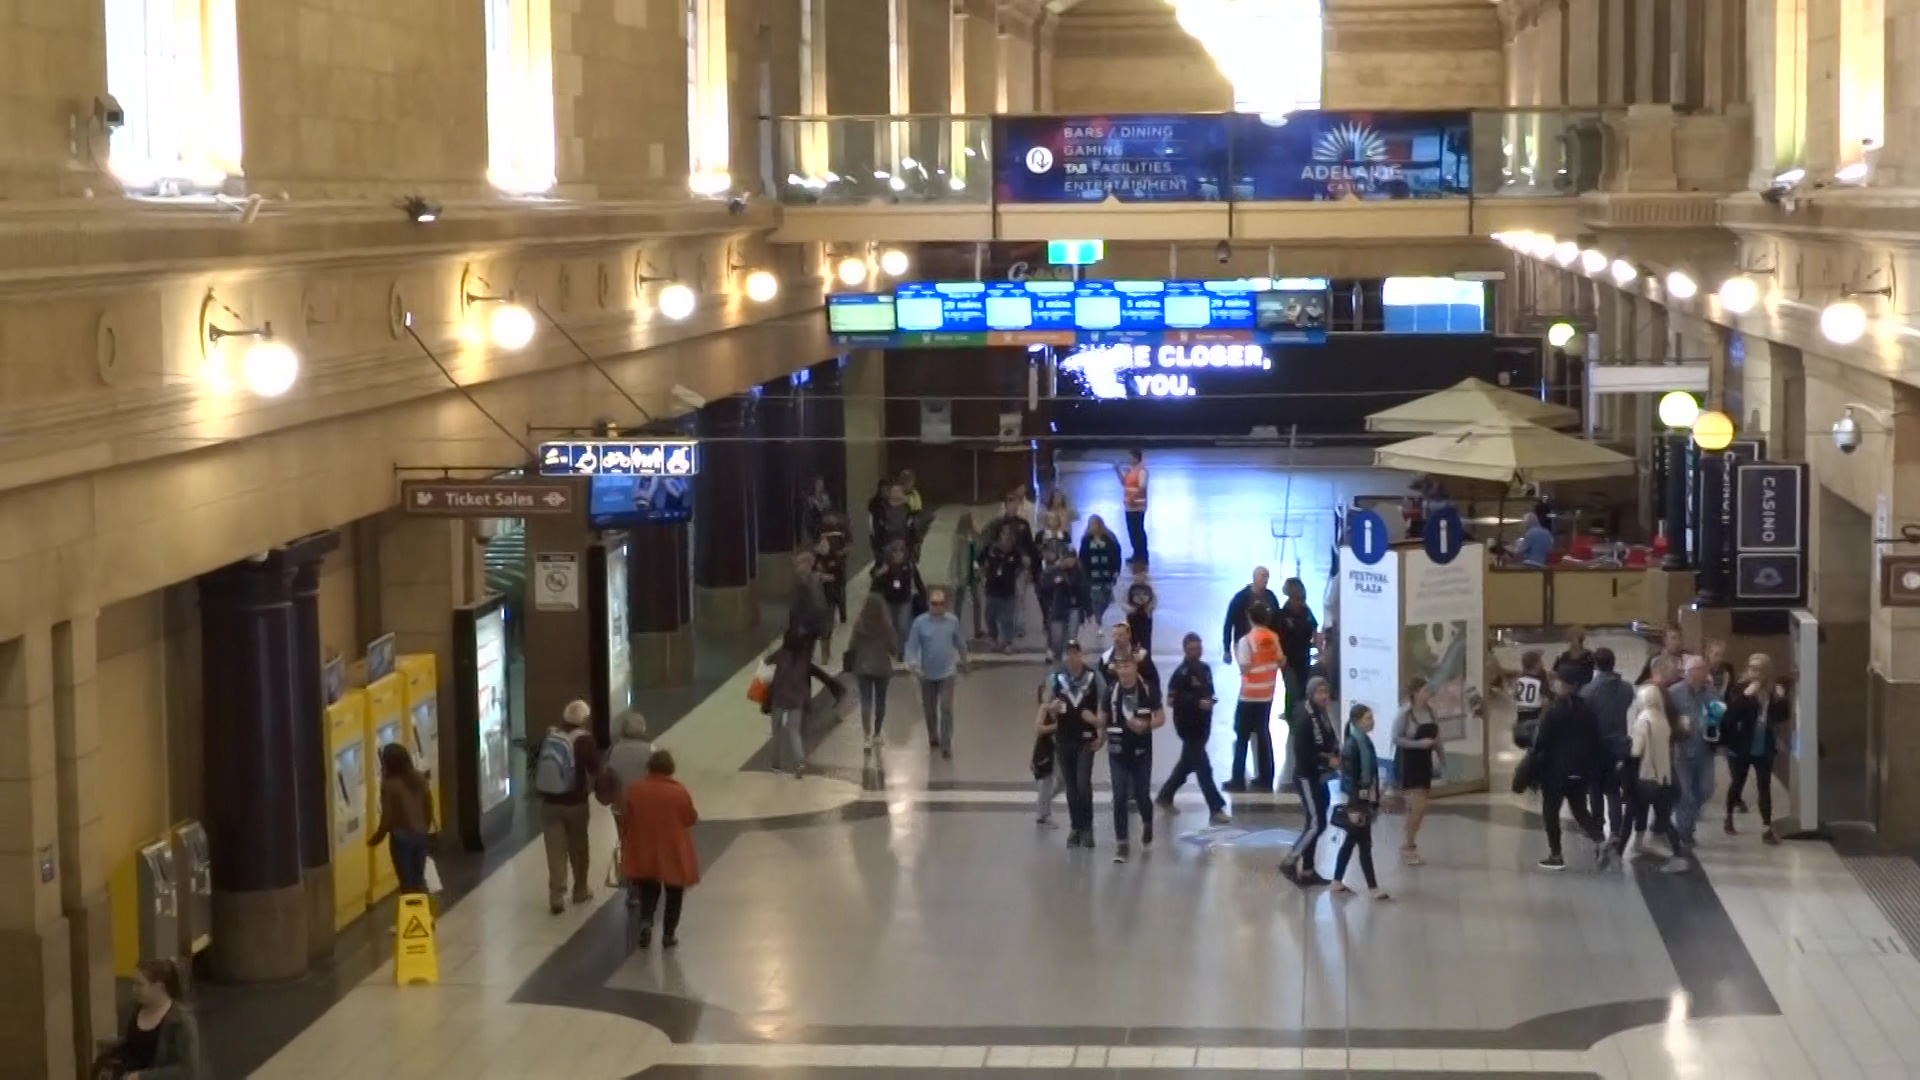

In [89]:
img_paths = glob('/home/ec2-user/SageMaker/MOT20/MOT20/train/MOT20-01/img1/*.jpg')
img_paths.sort()

# grab our labels
labels = []
with open('/home/ec2-user/SageMaker/MOT20/MOT20/train/MOT20-01/gt/gt.txt', 'r') as f:
    for line in f:
        labels.append(line.replace('\n','').split(','))

imgs = []
for imgp in img_paths:
    img = Image.open(imgp)
    imgs.append(img)
img

## Let's organize the labels into a frame level dictionary

In [76]:
lab_dict = {}

for i in range(1,len(img_paths)+1):
    lab_dict[i] = []
    
for lab in labels:
    lab_dict[int(lab[0])].append(lab)

## Now let's look at what the existing annotations look like

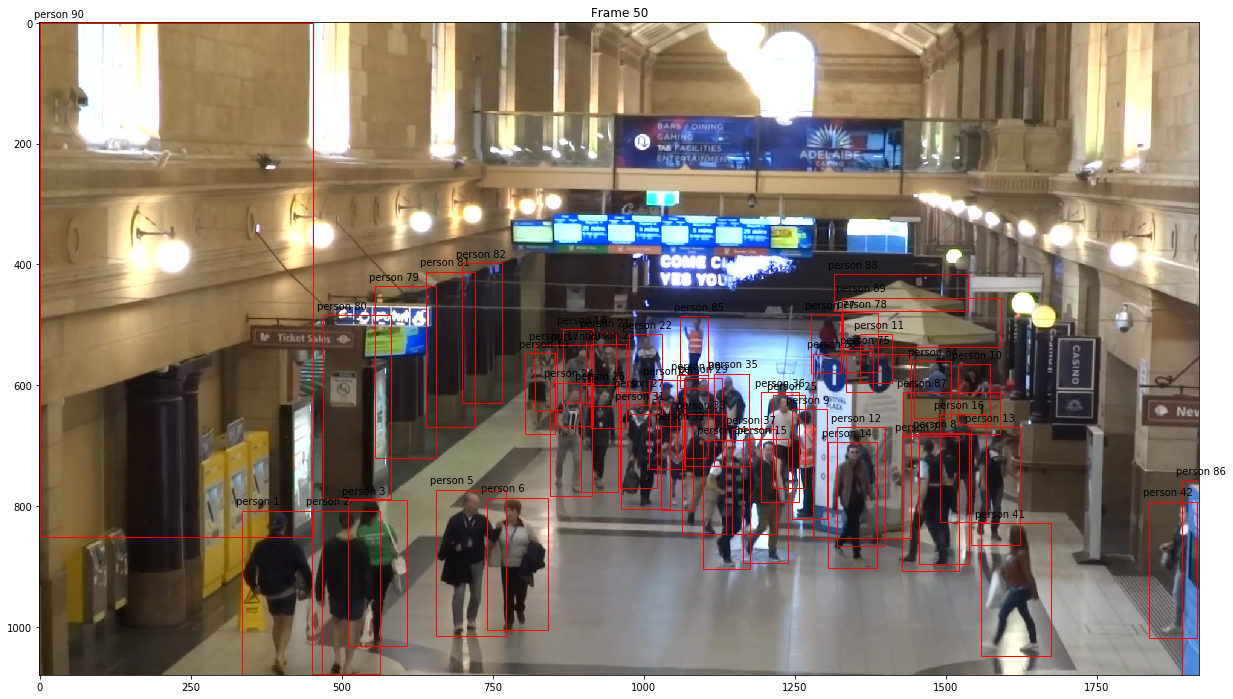

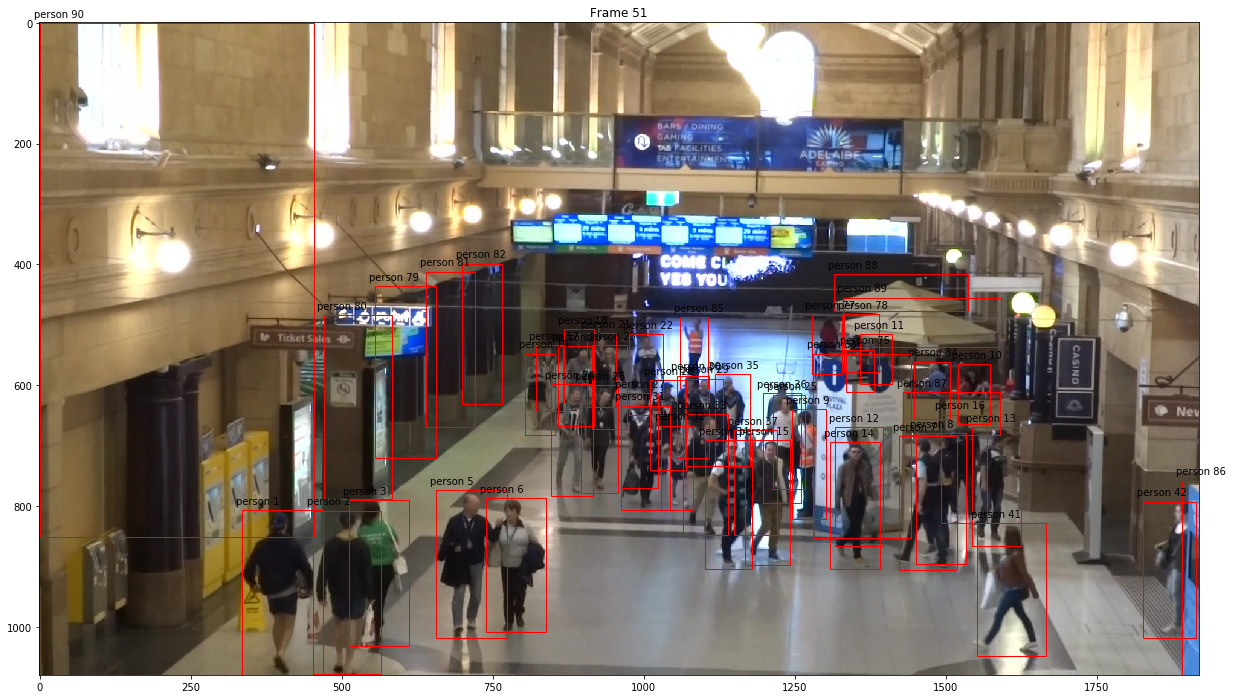

In [112]:
start_ind = 50
for j in range(start_ind,start_ind+2): 

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(24,12))
    ax.set_title(f'Frame {j}')

    # Display the image
    ax.imshow(imgs[j])

    for i,annot in enumerate(lab_dict[j]): 
        annot = np.array(annot, dtype=np.float32)
        rect = patches.Rectangle((annot[2], annot[3]), annot[4], annot[5] ,linewidth=1,edgecolor='r',facecolor='none') # 50,100),40,30
        ax.add_patch(rect)
        plt.text(annot[2]-10, annot[3]-10, f"person {int(annot[1])}", fontdict=None) #

## Let's take a look at how we would create a custom object tracking dataset

Instead of using the existing annotations, let's say we want to track something different, maybe we want to focus on people holding parcels. We first need to create our label categories so Ground Truth knows what labels to include for our workers.

In [93]:
# create label categories 

os.makedirs('/home/ec2-user/SageMaker/tracking_manifests', exist_ok=True)

labelcats = {
    "document-version": "2020-08-15",
    "auditLabelAttributeName": "Person",
#         "categoryGlobalAttributes": [
#             {
#                 "name": "applyToAllCategory",
#                 "description": "global attribute that applies to all label categories",
#                 "type": "string",
#                 "enum": [
#                     "foo",
#                 ]
#             }
#         ],
    "labels": [
        {
            "label": "Parcel",
            "attributes": [
                {
                    "name": "color",
                    "type": "string",
                    "enum": [
                        "Bag",
                        "Jacket",
                        "Backpack"
                    ]
                }
            ]
        }
    ],
    "instructions": {
        "shortInstruction": "Draw boxes around all parcels in the pictures",
        "fullInstruction": "Some useful instruction"
    }
}

filename = '/home/ec2-user/SageMaker/tracking_manifests/label_categories.json'
with open(filename,'w') as f:
    json.dump(labelcats,f)

s3.upload_file(Filename=filename, Bucket=bucket, Key='tracking_manifests/label_categories.json')

LABEL_CATEGORIES_S3_URI = f's3://{bucket}/tracking_manifests/label_categories.json'

In this case our image files are all split out, so we can just grab filepaths, if your data is in the form of video files, ffmpeg is a popular tool for splitting video files into individual image frames. 

ffmpeg for Python:
https://github.com/kkroening/ffmpeg-python

ffmpeg base utility
https://ffmpeg.org/

In [116]:
# get our target MP4 files, 
vids = glob('/home/ec2-user/SageMaker/MOT20/MOT20/train/*') 
vids.sort()
vids

# we assume we have folders with the same name as the mp4 file in the same root folder
vid_dict = {}
for vid in vids:
    files = glob(f"{vid}/img1/*jpg")
    files.sort()
    files = files[:1000]
    fileset = []
    for fil in files:
        fileset.append('/'.join(fil.split('/')[5:]))
    vid_dict[vid] = fileset

In [128]:
# generate sequences 
all_vids = {}
for vid in vid_dict:
    frames = []
    for i,v in enumerate(vid_dict[vid]):
        frame =         {
          "frame-no": i+1,
          "frame": f"{v.split('/')[-1]}",
          "unix-timestamp": 1589350528
        }
        frames.append(frame)
    all_vids[vid] = {
      "version": "2020-07-01",
      "seq-no": 1,
      "prefix": f"s3://{bucket}/{'/'.join(v.split('/')[:-1])}/", # .split('/')[1]
      "number-of-frames": len(vid_dict[vid]),
      "frames": frames
    }
    
# save sequences
for vid in all_vids:
    with open(f"/home/ec2-user/SageMaker/tracking_manifests/{vid.split('/')[-1]}_seq.json", 'w') as f:
        json.dump(all_vids[vid],f)

In [135]:
# create manifest 
man_dict = {}
for vid in all_vids:
    source_ref = f"s3://{bucket}/tracking_manifests/{vid.split('/')[-1]}_seq.json"
#     annot_labels = f"s3://{bucket}/nfl-data/gt_jobs/{vid.split('/')[-1]}-labels.json"

    manifest = {
        "source-ref": source_ref, 
#         'Person':annot_labels,
#         "Person-metadata":{"class-map": {"0": "Person"}, 
#                          "human-annotated": "yes", 
#                          "creation-date": "2020-05-25T12:53:54+0000", 
#                          "type": "groundtruth/video-object-tracking"}
    }
    man_dict[vid] = manifest
    
# save labels
# for vid in all_vids:
#     with open(f"/home/ec2-user/SageMaker/tracking_manifests/{vid.split('/')[-1]}.manifest", 'w') as f:
#         json.dump(man_dict[vid],f)
        
with open(f"/home/ec2-user/SageMaker/tracking_manifests/MOT20.manifest", 'w') as f:
    for vid in all_vids:    
        f.write(json.dumps(man_dict[vid]))
        f.write('\n')
        
print('Example manifest: ', manifest)

Example manifest:  {'source-ref': 's3://privisaa-bucket-virginia/tracking_manifests/MOT20-05_seq.json'}


In [137]:
!aws s3 cp --recursive /home/ec2-user/SageMaker/tracking_manifests s3://{bucket}/tracking_manifests/

upload: ../../tracking_manifests/MOT20-03_seq.json to s3://privisaa-bucket-virginia/tracking_manifests/MOT20-03_seq.json
upload: ../../tracking_manifests/MOT20-02_seq.json to s3://privisaa-bucket-virginia/tracking_manifests/MOT20-02_seq.json
upload: ../../tracking_manifests/MOT20.manifest to s3://privisaa-bucket-virginia/tracking_manifests/MOT20.manifest
upload: ../../tracking_manifests/.ipynb_checkpoints/MOT20-checkpoint.manifest to s3://privisaa-bucket-virginia/tracking_manifests/.ipynb_checkpoints/MOT20-checkpoint.manifest
upload: ../../tracking_manifests/MOT20-01_seq.json to s3://privisaa-bucket-virginia/tracking_manifests/MOT20-01_seq.json
upload: ../../tracking_manifests/label_categories.json to s3://privisaa-bucket-virginia/tracking_manifests/label_categories.json
upload: ../../tracking_manifests/.ipynb_checkpoints/MOT20-01_seq-checkpoint.json to s3://privisaa-bucket-virginia/tracking_manifests/.ipynb_checkpoints/MOT20-01_seq-checkpoint.json
upload: ../../tracking_manifests/MOT2

In [140]:
# generate jobs 

job_names = []
outputs = []

# for vid in all_vids:
LABELING_JOB_NAME = f"bag-track-mot20"
task = 'VideoObjectDetection'
job_names.append(LABELING_JOB_NAME)
INPUT_MANIFEST_S3_URI = f's3://{bucket}/tracking_manifests/MOT20.manifest'

createLabelingJob_request = {
  "LabelingJobName": LABELING_JOB_NAME,
  "HumanTaskConfig": {
    "AnnotationConsolidationConfig": {
      "AnnotationConsolidationLambdaArn": f"arn:aws:lambda:us-east-1:432418664414:function:ACS-{task}"
    }, # changed us-west-2 to us-east-1
    "MaxConcurrentTaskCount": 200,
    "NumberOfHumanWorkersPerDataObject": 1,
    "PreHumanTaskLambdaArn": f"arn:aws:lambda:us-east-1:432418664414:function:PRE-{task}",
    "TaskAvailabilityLifetimeInSeconds": 864000,
    "TaskDescription": "Draw boxes around parcels!",
    "TaskKeywords": [
      "Image Classification",
      "Labeling"
    ],
    "TaskTimeLimitInSeconds": 28800,
    "TaskTitle": LABELING_JOB_NAME,
    "UiConfig": {
      "HumanTaskUiArn": f'arn:aws:sagemaker:us-east-1:394669845002:human-task-ui/VideoObjectDetection'
    },
    "WorkteamArn": WORKTEAM_ARN
  },
  "InputConfig": {
    "DataAttributes": {
      "ContentClassifiers": [
        "FreeOfPersonallyIdentifiableInformation",
        "FreeOfAdultContent"
      ]
    },
    "DataSource": {
      "S3DataSource": {
        "ManifestS3Uri": INPUT_MANIFEST_S3_URI
      }
    }
  },
  "LabelAttributeName": "Person-ref",
  "LabelCategoryConfigS3Uri": LABEL_CATEGORIES_S3_URI,
  "OutputConfig": {
    "S3OutputPath": f"s3://{bucket}/job_results"
  },
  "RoleArn": "arn:aws:iam::209419068016:role/service-role/AmazonSageMaker-ExecutionRole-20200212T154382",
  "StoppingConditions": {
    "MaxPercentageOfInputDatasetLabeled": 100
  }
}
print(createLabelingJob_request)
out = sagemaker_cl.create_labeling_job(**createLabelingJob_request)
outputs.append(out)
print(out)

{'LabelingJobName': 'bag-track-mot20', 'HumanTaskConfig': {'AnnotationConsolidationConfig': {'AnnotationConsolidationLambdaArn': 'arn:aws:lambda:us-east-1:432418664414:function:ACS-VideoObjectDetection'}, 'MaxConcurrentTaskCount': 200, 'NumberOfHumanWorkersPerDataObject': 1, 'PreHumanTaskLambdaArn': 'arn:aws:lambda:us-east-1:432418664414:function:PRE-VideoObjectDetection', 'TaskAvailabilityLifetimeInSeconds': 864000, 'TaskDescription': 'Draw boxes around parcels!', 'TaskKeywords': ['Image Classification', 'Labeling'], 'TaskTimeLimitInSeconds': 28800, 'TaskTitle': 'bag-track-mot20', 'UiConfig': {'HumanTaskUiArn': 'arn:aws:sagemaker:us-east-1:394669845002:human-task-ui/VideoObjectDetection'}, 'WorkteamArn': 'arn:aws:sagemaker:us-east-1:209419068016:workteam/private-crowd/ijp-private-workteam'}, 'InputConfig': {'DataAttributes': {'ContentClassifiers': ['FreeOfPersonallyIdentifiableInformation', 'FreeOfAdultContent']}, 'DataSource': {'S3DataSource': {'ManifestS3Uri': 's3://privisaa-bucket-